# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Output a trimmed .csv/HDF5 that holds the data as a dataframe


Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [13]:
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import numpy  as np 
import pandas as pd
import os 
import shutil
from pathlib import Path
from cycler import cycler

loc_directory =  os.getcwd() + '/Data' #home PC
print(loc_directory)
mlr_directory =  os.getcwd() + '/MLR_data' #home PC

util_directory = os.getcwd() +  '/util_data' #home PC
#directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop

trim_directory = os.getcwd() + '/TrimmedData'
print(trim_directory)

/home/rdailey/repos/homer/ClimateStudies/OutputProcessing/Data
/home/rdailey/repos/homer/ClimateStudies/OutputProcessing/TrimmedData


## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [14]:
# reads, maps all sheets for locational variance studies
files = os.listdir(loc_directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(loc_directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,9717.203600,7,3000,19318,146304176,0.120247,1774010.500,84637992,82.697044,1563982.500,...,0,7287902.50,18121926.0,10762500,37085996,267750,3.863608,3361338.25,19318.039062,15454.430664
1,9626.916355,7,3000,20055,147095840,0.120894,1791503.125,84821600,82.707527,1563088.375,...,0,7220187.50,17953546.0,10762500,37085996,267750,4.011008,3380700.75,20055.041016,16044.032227
2,12342.332860,6,3000,19997,147284448,0.121052,1783141.000,85300880,82.047417,1622996.375,...,0,9256750.00,23017614.0,9225000,31787996,229500,3.999408,3405818.25,19997.039062,15997.631836
3,9707.853087,7,3000,20334,147485664,0.121211,1798234.250,84977440,82.784897,1556145.250,...,0,7280890.00,18104488.0,10762500,37085996,267750,4.066808,3386342.00,20334.041016,16267.232422
4,13972.567383,5,3000,20721,147681712,0.121381,1796524.000,85232944,80.746681,1740652.000,...,0,10479426.00,26057892.0,7687500,26489996,191250,4.144208,3524808.25,20721.041016,16576.833984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10735.413042,3,4000,7268,160968720,0.132282,1893683.500,95142600,66.130295,3064937.250,...,0,8051560.00,20020818.0,4612500,15893998,114750,1.453603,3412067.50,7268.014648,5814.411621
1996,5289.826586,4,4000,10556,160970480,0.132295,1934742.500,93717120,66.466148,3033207.500,...,0,3967370.00,9865168.0,6150000,21191998,153000,2.111204,4077359.00,10556.021484,8444.816406
1997,9101.653320,4,4000,12595,160970944,0.132225,1832509.375,97271288,71.572815,2572809.000,...,0,6826240.00,16973966.0,6150000,21191998,153000,2.519005,3970566.00,12595.025391,10076.020508
1998,5506.897522,4,4000,11635,160972208,0.132285,1919523.625,94247864,67.322884,2955959.000,...,0,4130173.25,10269991.0,6150000,21191998,153000,2.327005,4129672.00,11635.023438,9308.018555


In [15]:
# reads, maps all sheets for MLR variance studies
mlr_files = os.listdir(mlr_directory)
mlr_output_df = {} #creates empty dictionary
mlr_names = [] #creates empty list for future name storage
for file in mlr_files:
    if file.endswith('.xlsx'):
        mlr_xls = pd.ExcelFile(mlr_directory + '/' + file) #reads file
        mlr_names = mlr_names + mlr_xls.sheet_names
        for sheet_name in mlr_xls.sheet_names: #pulls individual sheets
            mlr_output_df[sheet_name] = mlr_xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(mlr_output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,8400.087500,NaN,5000,1500.0,78370784,0.064357,9.078901e+05,46811720,26.248690,6703879.5,...,0,6300065.5,19455522.0,NaN,NaN,NaN,0.300001,301970.437500,1500.003052,1200.002441
1,8100.084375,NaN,5000,1500.0,78408192,0.064389,9.154390e+05,46586720,25.203970,6798717.0,...,0,6075063.5,18760682.0,NaN,NaN,NaN,0.300001,313344.562500,1500.003052,1200.002441
2,8518.400533,NaN,5000,1463.0,78416336,0.064394,9.070109e+05,46887840,26.430204,6687436.0,...,0,6388800.5,19729548.0,NaN,NaN,NaN,0.292601,283585.406250,1463.002930,1170.402344
3,8000.083333,NaN,5000,1250.0,78423584,0.064406,9.204919e+05,46426468,24.016087,6906249.5,...,0,6000062.5,18529068.0,NaN,NaN,NaN,0.250001,243308.093750,1250.002441,1000.002014
4,8171.175784,NaN,5000,1554.0,78423592,0.064400,9.138184e+05,46658452,25.682077,6755447.5,...,0,6128382.0,18925338.0,NaN,NaN,NaN,0.310801,333990.656250,1554.003052,1243.202515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9749.981785,1.0,7000,495.0,108639968,0.089194,1.254888e+06,65018936,0.000000,9202906.0,...,0,7312486.5,22582024.0,1537500.0,1931949.625,38250.0,0.099000,28295.386719,495.000977,396.000793
1996,14400.150000,NaN,6000,12000.0,108645512,0.089198,1.316228e+06,62892268,23.172131,6987338.5,...,0,10800112.0,33352324.0,NaN,NaN,NaN,2.400005,359803.875000,12000.024414,9600.019531
1997,24000.250000,3.0,5000,NaN,108664280,0.089241,1.324806e+06,62612844,37.810287,5653240.5,...,0,18000188.0,55587204.0,4612500.0,5795848.500,114750.0,NaN,NaN,NaN,NaN
1998,NaN,5.0,5000,8526.0,108671344,0.089287,1.670738e+06,50595020,2.738913,8833800.0,...,0,NaN,NaN,7687500.0,9659748.000,191250.0,1.705203,668805.562500,8526.016602,6820.813477


In [16]:
# Populating list of proper utility sheet names
os.chdir('/home/rdailey/repos/homer/ClimateStudies/ProductionCases/UtilityConnection')
homer_util_dirs = os.path.abspath(os.getcwd()) 
print(homer_util_dirs)
fixed_util_names = []
for path, subdirs, files in os.walk(homer_util_dirs):
    for name in files:
        if name[-6:] == '.homer':
            #print(name.replace('.homer',''))
            fixed_util_names.append(name.replace('.homer',""))
print(len(fixed_util_names))
os.chdir('/home/rdailey/repos/homer/ClimateStudies/OutputProcessing')

/home/rdailey/repos/homer/ClimateStudies/ProductionCases/UtilityConnection
620


In [17]:
# reads, maps all sheets for utility variance studies
util_files = os.listdir(util_directory)
print(os.listdir)
util_output_df = {} #creates empty dictionary
util_names = [] #creates empty list for future name storage

for file in util_files:
    if file.endswith('.xlsx'):
        util_xls = pd.ExcelFile(util_directory + '/' + file) #reads file
        #print(util_xls.sheet_names)
        util_names = util_names + util_xls.sheet_names

        
        #util_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
        #                                                 'Cost/COE\n($)','GenMin'])
        #util_new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
        n_util = len(util_names)
                    

        
                
        # for i in fixed_util_names:
        #     #print(i)
        #     index = fixed_util_names.index(i)
        #     match = [match for match in fixed_util_names if i in match]
        #     fixed_util_names[index] = match
            
        #print(fixed_util_names)
        for i in fixed_util_names:
            index = fixed_util_names.index(i)
            match = [match for match in fixed_util_names if i in match]
            fixed_util_names[index] = ''.join(match)
            for sheet_name in util_xls.sheet_names: #pulls individual sheets
                if sheet_name in fixed_util_names[index]:
                    util_output_df[fixed_util_names[index]] = util_xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
                    print('corrected', sheet_name, ' to ', fixed_util_names[index])
display(util_output_df[fixed_util_names[index]])

<built-in function listdir>
corrected Utility1dot3MWe12CentsMedfordOR  to  Utility1dot3MWe12CentsMedfordORCsa
corrected Utility1dot3MWe12CentsNOLACfa  to  Utility1dot3MWe12CentsNOLACfa
corrected Utility1dot3MWe12CentsCheyenneW  to  Utility1dot3MWe12CentsCheyenneWYBsk
corrected Utility1dot3MWe12CentsJacksonMS  to  Utility1dot3MWe12CentsJacksonMSCfa
corrected Utility1dot3MWe12CentsBentonCou  to  Utility1dot3MWe12CentsBentonCountyOregonCsb
corrected Utility1dot3MWe12CentsMiamiAf  to  Utility1dot3MWe12CentsMiamiAf
corrected Utility1dot3MWe12CentsUPMichDfb  to  Utility1dot3MWe12CentsUPMichDfb
corrected Utility1dot3MWe12CentsTexasOilB  to  Utility1dot3MWe12CentsTexasOilBSh
corrected Utility1dot3MWe12CentsBangorMED  to  Utility1dot3MWe12CentsBangorMEDfb
corrected Utility1dot3MWe12CentsRaleighNC  to  Utility1dot3MWe12CentsRaleighNCCfa
corrected Utility1dot3MWe12CentsSyracuseD  to  Utility1dot3MWe12CentsSyracuseDfb
corrected Utility1dot3MWe12CentsSouthBend  to  Utility1dot3MWe12CentsSouthBendIN

corrected Utility1dot3MWe24CentsRaleighNC  to  Utility1dot3MWe24CentsRaleighNCCfa
corrected Utility1dot3MWe24CentsMemphisTN  to  Utility1dot3MWe24CentsMemphisTNCfa
corrected Utility1dot3MWe24CentsBlaineCou  to  Utility1dot3MWe24CentsBlaineCountyMontanaBSk
corrected Utility1dot3MWe24CentsPuebloBsk  to  Utility1dot3MWe24CentsPuebloBsk
corrected Utility1dot3MWe24CentsLincolnNE  to  Utility1dot3MWe24CentsLincolnNEDfa
corrected Utility1dot3MWe24CentsVegasNVBw  to  Utility1dot3MWe24CentsVegasNVBwh
corrected Utility1dot3MWe24CentsFlagstaff  to  Utility1dot3MWe24CentsFlagstaffDsb
corrected Utility1dot3MWe24CentsMobileALC  to  Utility1dot3MWe24CentsMobileALCfa
corrected Utility1dot3MWe24CentsEverglade  to  Utility1dot3MWe24CentsEvergladesAM
corrected Utility1dot3MWe24CentsMoscowIDC  to  Utility1dot3MWe24CentsMoscowIDCsb
corrected Utility1dot3MWe24CentsSacrament  to  Utility1dot3MWe24CentsSacramentoCsa
corrected Utility1dot3MWe24CentsDetroitMI  to  Utility1dot3MWe24CentsDetroitMIDfa
corrected Ut

corrected Utility2dot6MWe6CentsRichmondVA  to  Utility2dot6MWe6CentsRichmondVACfa
corrected Utility2dot6MWe6CentsIdahoFalls  to  Utility2dot6MWe6CentsIdahoFallsDfb
corrected Utility2dot6MWe6CentsLaredoTXBS  to  Utility2dot6MWe6CentsLaredoTXBSh
corrected Utility2dot6MWe6CentsBismarckND  to  Utility2dot6MWe6CentsBismarckNDDfb
corrected Utility2dot6MWe6CentsMemphisTNC  to  Utility2dot6MWe6CentsMemphisTNCfa
corrected Utility2dot6MWe6CentsDetroitMID  to  Utility2dot6MWe6CentsDetroitMIDfa
corrected Utility2dot6MWe6CentsKootenaiCo  to  Utility2dot6MWe6CentsKootenaiCountyIDDsb
corrected Utility2dot6MWe6CentsBlaineCoun  to  Utility2dot6MWe6CentsBlaineCountyMontanaBSk
corrected Utility2dot6MWe6CentsTexasOilBS  to  Utility2dot6MWe6CentsTexasOilBSh
corrected Utility2dot6MWe6CentsSacramento  to  Utility2dot6MWe6CentsSacramentoCsa
corrected Utility2dot6MWe6CentsSouthBendI  to  Utility2dot6MWe6CentsSouthBendINDfa
corrected Utility2dot6MWe6CentsCrestedBut  to  Utility2dot6MWe6CentsCrestedButteCODfc
co

corrected Utility2dot6MWe12CentsAtlantaGA  to  Utility2dot6MWe12CentsAtlantaGACfa
corrected Utility2dot6MWe12CentsKootenaiC  to  Utility2dot6MWe12CentsKootenaiCountyIDDsb
corrected Utility2dot6MWe12CentsPrescottA  to  Utility2dot6MWe12CentsPrescottAZCsa
corrected Utility2dot6MWe12CentsLancaster  to  Utility2dot6MWe12CentsLancasterPADfa
corrected Utility2dot6MWe12CentsOKCityCfa  to  Utility2dot6MWe12CentsOKCityCfa
corrected Utility2dot6MWe12CentsRaleighNC  to  Utility2dot6MWe12CentsRaleighNCCfa
corrected Utility2dot6MWe12CentsEielsonAF  to  Utility2dot6MWe12CentsEielsonAFBDfC
corrected Utility2dot6MWe12CentsMiamiAf  to  Utility2dot6MWe12CentsMiamiAf
corrected Utility2dot6MWe24CentsSyracuseD  to  Utility2dot6MWe24CentsSyracuseDfb
corrected Utility2dot6MWe24CentsORNLCfa  to  Utility2dot6MWe24CentsORNLCfa
corrected Utility2dot6MWe24CentsLaredoTXB  to  Utility2dot6MWe24CentsLaredoTXBSh
corrected Utility2dot6MWe24CentsBangorMED  to  Utility2dot6MWe24CentsBangorMEDfb
corrected Utility2dot6MWe

corrected Utility2dot6MWe18CentsRichmondV  to  Utility2dot6MWe18CentsRichmondVACfa
corrected Utility2dot6MWe18CentsPhoenixAZ  to  Utility2dot6MWe18CentsPhoenixAZBwh
corrected Utility2dot6MWe18CentsOKCityCfa  to  Utility2dot6MWe18CentsOKCityCfa
corrected Utility2dot6MWe18CentsCoalville  to  Utility2dot6MWe18CentsCoalvilleUTDfb
corrected Utility2dot6MWe18CentsDesMoines  to  Utility2dot6MWe18CentsDesMoinesIADfa
corrected Utility2dot6MWe18CentsSyracuseD  to  Utility2dot6MWe18CentsSyracuseDfb
corrected Utility2dot6MWe18CentsBlaineCou  to  Utility2dot6MWe18CentsBlaineCountyMontanaBSk
corrected Utility2dot6MWe18CentsBentonCou  to  Utility2dot6MWe18CentsBentonCountyOregonCsb
corrected Utility2dot6MWe18CentsKauaiCfb  to  Utility2dot6MWe18CentsKauaiCfb
corrected Utility2dot6MWe18CentsButtonwil  to  Utility2dot6MWe18CentsButtonwillowBwk
corrected Utility2dot6MWe18CentsLincolnNE  to  Utility2dot6MWe18CentsLincolnNEDfa
corrected Utility2dot6MWe18CentsGreatFall  to  Utility2dot6MWe18CentsGreatFallsM

corrected Utility2dot6MWe30CentsHiloAf  to  Utility2dot6MWe30CentsHiloAf
corrected Utility2dot6MWe30CentsChicagoDf  to  Utility2dot6MWe30CentsChicagoDfa
corrected Utility2dot6MWe30CentsColumbiaM  to  Utility2dot6MWe30CentsColumbiaMOCfa
corrected Utility2dot6MWe30CentsCarsonCit  to  Utility2dot6MWe30CentsCarsonCityNVBsk
corrected Utility2dot6MWe30CentsYumaAZBwh  to  Utility2dot6MWe30CentsYumaAZBwh
corrected Utility2dot6MWe30CentsBentonCou  to  Utility2dot6MWe30CentsBentonCountyOregonCsb
corrected Utility2dot6MWe30CentsLongviewC  to  Utility2dot6MWe30CentsLongviewCsb
corrected Utility2dot6MWe30CentsLancaster  to  Utility2dot6MWe30CentsLancasterPADfa
corrected Utility2dot6MWe30CentsBendOreBs  to  Utility2dot6MWe30CentsBendOreBsk
corrected Utility2dot6MWe30CentsSyracuseD  to  Utility2dot6MWe30CentsSyracuseDfb
corrected Utility2dot6MWe30CentsLincolnNE  to  Utility2dot6MWe30CentsLincolnNEDfa
corrected Utility2dot6MWe30CentsLosAlamos  to  Utility2dot6MWe30CentsLosAlamosNMDfb
corrected Utility

corrected Utility1dot3MWe30CentsYumaAZBwh  to  Utility1dot3MWe30CentsYumaAZBwh
corrected Utility1dot3MWe30CentsVegasNVBw  to  Utility1dot3MWe30CentsVegasNVBwh
corrected Utility1dot3MWe30CentsNeahBayCf  to  Utility1dot3MWe30CentsNeahBayCfb
corrected Utility1dot3MWe30CentsCheyenneW  to  Utility1dot3MWe30CentsCheyenneWYBsk
corrected Utility1dot3MWe30CentsColumbiaM  to  Utility1dot3MWe30CentsColumbiaMOCfa
corrected Utility1dot3MWe30CentsCoalville  to  Utility1dot3MWe30CentsCoalvilleUTDfb
corrected Utility1dot3MWe30CentsEverglade  to  Utility1dot3MWe30CentsEvergladesAM
corrected Utility1dot3MWe30CentsSouthBend  to  Utility1dot3MWe30CentsSouthBendINDfa
corrected Utility1dot3MWe30CentsBangorMED  to  Utility1dot3MWe30CentsBangorMEDfb
corrected Utility1dot3MWe30CentsCrestedBu  to  Utility1dot3MWe30CentsCrestedButteCODfc
corrected Utility1dot3MWe30CentsBlaineCou  to  Utility1dot3MWe30CentsBlaineCountyMontanaBSk
corrected Utility1dot3MWe30CentsChicagoDf  to  Utility1dot3MWe30CentsChicagoDfa
corre

,Architecture/PV\n(kW),Architecture/G1500,Architecture/1kWh LI,Architecture/Grid\n(kW),Architecture/Converter\n(kW),Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),...,G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh),Converter/Rectifier Mean Output\n(kW),Converter/Inverter Mean Output\n(kW),Grid/Energy Purchased\n(kWh),Grid/Energy Sold\n(kWh)
0,17854.413316,4,33801,2600,10304.000196,128493608,0.105610,2802470.50,31077254,72.274178,...,13626349.0,153000,6.760213,2965067.25,33801.066406,27040.853516,358.808533,305.052979,9704472,-7.844392e-12
1,18350.846615,4,33276,2600,23902.855820,128506984,0.105620,2796903.00,31284154,72.325722,...,13626349.0,153000,6.655213,2962585.50,33276.066406,26620.853516,358.478333,304.797668,9686437,-4.892087e-12
2,18325.647439,4,33308,2600,19154.371607,128508992,0.105622,2797327.25,31271418,72.323181,...,13626349.0,153000,6.661613,2962753.75,33308.066406,26646.453125,358.500519,304.815002,9687340,-5.741185e-12
3,17965.382978,4,33704,2600,8378.943848,128517256,0.105628,2801763.25,31125480,72.286026,...,13626349.0,153000,6.740813,2964736.50,33704.066406,26963.253906,358.762909,305.018982,9700384,-2.756906e-12
4,18673.050350,4,32952,2600,12253.661050,128518072,0.105629,2793783.75,31403674,72.358116,...,13626349.0,153000,6.590413,2961146.25,32952.066406,26361.652344,358.285645,304.649597,9675119,-7.005951e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,19458.065225,3,35165,2600,16466.177561,130428328,0.107170,2854200.75,31213780,70.639915,...,10219762.0,114750,7.033014,3222066.50,35165.070312,28132.056641,389.798676,331.493683,10279336,-9.952039e-12
1996,20146.093731,3,34425,2600,25771.367848,130428640,0.107174,2846356.50,31486766,70.705399,...,10219762.0,114750,6.885014,3217583.00,34425.070312,27540.054688,389.214661,331.032410,10256029,-3.726797e-12
1997,20462.141598,3,34088,2600,24825.307883,130428912,0.107177,2842878.50,31607940,70.734062,...,10219762.0,114750,6.817614,3215346.50,34088.066406,27270.455078,388.925293,330.802338,10245717,-1.037748e-11
1998,21369.685409,3,33126,2600,8254.217469,130429040,0.107187,2833214.75,31943984,70.811996,...,10219762.0,114750,6.625213,3208737.00,33126.066406,26500.853516,388.072052,330.122314,10217529,-4.181544e-12


In [18]:
#pulling interesting data points from each LOC VAR Case
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n = len(names)
display(n)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-3]
                case_num = name[:5]
    KCC = KCC.lower()
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
  

    
# Data Cleanup    
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel(trim_directory +'/'+ "LocationalVarianceTrimmed.xlsx")


display(opt_out)
#display(new_cases)  

639

KCC  Architecture/PV\n(kW)  Architecture/G1500  \
CaseNum CaseName                                                     
Case1   Anchorage   dfc           67432.441304                28.0   
        Ashland     dfb           39799.095877                19.0   
        AtlantaGA   cfa           92802.980815                 3.0   
        BangorME    dfb           62211.324125                20.0   
        BendOre     bsk           40050.377085                23.0   
...                 ...                    ...                 ...   
Case8   RaleighNC   cfa           32126.631249                 7.0   
        ReddingCA   csa           26843.735929                 4.0   
        RichmondVA  cfa           37944.276532                 5.0   
        Sacramento  csa           19589.237011                 2.0   
        Syracuse    dfb           74305.687555                13.0   

                   Architecture/GenLarge\n(kW) Architecture/1kWh LI  \
CaseNum CaseName                                                      
Case1   Anchorage                          NaN               238148   
        Ashland                            NaN                83635   
        AtlantaGA                          NaN               121958   
        BangorME                           NaN               143357   
        BendOre                            NaN                93120   
...                                        ...                  ...   
Case8   RaleighNC                       3000.0                40384   
        ReddingCA                         3000                38229   
        RichmondVA                        3000                46024   
        Sacramento                      3000.0                32783   
        Syracuse                           NaN                77203   

                    Cost/COE\n($) GenMin  
CaseNum CaseName                          
Case1   Anchorage        0.437239    NaN  
        Ashland          0.207991    NaN  
        AtlantaGA        0.252627    NaN  
        BangorME         0.301640    NaN  
        BendOre          0.233319    NaN  
...                           ...    ...  
Case8   RaleighNC        0.236074    NaN  
        ReddingCA        0.233377    NaN  
        RichmondVA       0.244868    NaN  
        Sacramento       0.216778    NaN  
        Syracuse         0.220980    NaN  

[639 rows x 7 columns]

In [19]:
#pulling interesting data points from each MLR  Case
mlr_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
mlr_new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n_mlr = len(mlr_names)
for i in range(n_mlr):
    name = mlr_names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[5:-2]
                case_num = name[:5]
                mlr      = name[8:10]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[5:-2]
                case_num = name[:5]
                mlr      = name[8:10]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[10:-3]
                case_num = name[:5]
                mlr      = name[8:10]
                #print(mlr)
    if "AZYuma".casefold() in Location.casefold():
        print(Location)
        Location = Location.replace("AZYuma","YumaAZ")
        print(Location)
    KCC = KCC.lower()
    # print(name)
    mlr_filtered_out = mlr_output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI', 'Cost/COE\n($)']) #Filtering objects of interest
    mlr_filtered_out['CaseName'] = Location #adding actual case name to series
    mlr_filtered_out['CaseNum'] = case_num # adding case num to series
    mlr_filtered_out['KCC'] = KCC
    mlr_filtered_out['mlr'] = mlr
    mlr_framed = mlr_filtered_out.iloc[[0]] #making the actual df
    mlr_framed.set_index(['CaseNum','CaseName','mlr'], inplace=True, drop=True) #building df w/ casename and num
    mlr_opt_out = pd.concat([mlr_framed,mlr_opt_out]) #concating all DFs together
  

    
# Data Cleanup    
mlr_opt_out = mlr_opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
mlr_opt_out = mlr_opt_out.sort_index()
mlr_opt_out.to_csv(trim_directory +'/'+ "MLRTrimmed.csv")


display(mlr_opt_out)
#display(new_cases)  

AZYuma
YumaAZ
AZYuma
YumaAZ


KCC  Architecture/PV\n(kW)  Architecture/G1500  \
CaseNum CaseName  mlr                                                   
Case2   Anchorage 50   dfc            6900.071875                 NaN   
                  60   dfc            7111.227366                 NaN   
                  70   dfc            7123.984923                 NaN   
                  80   dfc            7123.984923                 NaN   
                  90   dfc            7123.984923                 NaN   
...                    ...                    ...                 ...   
Case4   YumaAZ    60   bwh           18946.593167                 2.0   
                  70   bwh           18946.593167                 2.0   
                  80   bwh           18946.593167                 2.0   
                  90   bwh           18946.593167                 2.0   
                  95   bwh           18946.593167                 2.0   

                      Architecture/GenLarge\n(kW)  Architecture/1kWh LI  \
CaseNum CaseName  mlr                                                     
Case2   Anchorage 50                         5000                1500.0   
                  60                         5000                1655.0   
                  70                         5000                1606.0   
                  80                         5000                1606.0   
                  90                         5000                1606.0   
...                                           ...                   ...   
Case4   YumaAZ    60                       3000.0               34290.0   
                  70                       3000.0               34290.0   
                  80                       3000.0               34290.0   
                  90                       3000.0               34290.0   
                  95                       3000.0               34290.0   

                       Cost/COE\n($) GenMin  
CaseNum CaseName  mlr                        
Case2   Anchorage 50        0.071879    NaN  
                  60        0.071792    NaN  
                  70        0.071756    NaN  
                  80        0.071734    NaN  
                  90        0.071719    NaN  
...                              ...    ...  
Case4   YumaAZ    60        0.159500    NaN  
                  70        0.159500    NaN  
                  80        0.159500    NaN  
                  90        0.159500    NaN  
                  95        0.159500    NaN  

[1116 rows x 7 columns]

In [45]:
#pulling interesting data points from each util  Case    
#os.chdir('OutputProcessing')
test_str = 'Grid/Energy Purchased\n(kWh)'
util_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500',
                                     test_str,'Architecture/1kWh LI','Cost/COE\n($)'])
for i in range(n_util):
    name = fixed_util_names[i] # Grabs Sheet Name
    name = ''.join(name)
    if "6cents".casefold() in name.casefold():
        case_info = name[:21]
        price = name[15:16]
        if 'Utility2dot6MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility2dot6MWe' # used for string cleanup later
            util = '2.6MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        elif'Utility1dot3MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility1dot3MWe' # used for string cleanup later
            util = '1.3MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        else:
            print('error')
        KCC = name[-3:]     #grabs KCC from last 3 values
        #print(KCC)
        if KCC[-2:].casefold() == ('Af'.casefold()) or (KCC[-2:].casefold() == 'Am'.casefold()):
                if KCC[-2:].casefold() == 'Af'.casefold():
                    KCC = 'Af'
                else: 
                    KCC = 'Am'
                Location = name[:-2]
                Location = Location.replace(KCC, "")
                Location = Location.replace(utility_str, "")
                Location = Location.replace(str(price), "")
                Location = Location.replace("Cents", "")
                case_num = name[:5]
               #else:
               #    Location = name[5:-2]
               #    case_num = name[:5]
        else: 
                Location = Location.replace(KCC, "")
                Location = Location.replace(str(price), "")
    else:     
        case_info = name[:22]
        price = name[15:17]
        if 'Utility2dot6MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility2dot6MWe' # used for string cleanup later
            util = '2.6MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        elif'Utility1dot3MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility1dot3MWe' # used for string cleanup later
            util = '1.3MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        else:
            print('error')
        KCC = name[-3:]     #grabs KCC from last 3 values
        #print(KCC)
        if KCC[-2:].casefold() == ('Af'.casefold()) or (KCC[-2:].casefold() == 'Am'.casefold()):
                if KCC[-2:].casefold() == 'Af'.casefold():
                    KCC = 'Af'
                else: 
                    KCC = 'Am'
                Location = name[:-2]
                Location = Location.replace(KCC, "")
                Location = Location.replace(utility_str, "")
                Location = Location.replace(str(price), "")
                Location = Location.replace("Cents", "")
                case_num = name[:5]
               #else:
               #    Location = name[5:-2]
               #    case_num = name[:5]
        else: 
                Location = Location.replace(KCC, "")
                Location = Location.replace(str(price), "")
        #print(utility_str)

    KCC = KCC.lower()
    #print(name)
    util_filtered_out = util_output_df[name].filter(['Architecture/PV\n(kW)',test_str, 'Architecture/G1500', 'Architecture/1kWh LI', 'Cost/COE\n($)']) #Filtering objects of interest
    #print(Location)
    util_filtered_out['CaseName'] = Location #adding actual case name to series
    util_filtered_out['CaseNum'] = util # adding case num to series
    util_filtered_out['Price'] = price # adding case num to series
    util_filtered_out['KCC'] = KCC
    #util_filtered_out['util'] = util add back to .set_index line
    util_framed = util_filtered_out.iloc[[0]] #making the actual df
    util_framed.set_index(['CaseNum','Price','CaseName','KCC'], inplace=True, drop=True) #building df w/ casename and num
    util_opt_out = pd.concat([util_framed,util_opt_out]) #concating all DFs together
  

    
# Data Cleanup    
#util_opt_out = util_opt_out[ ['GenMin'] + [ col for col in util_opt_out.columns if col != 'GenMin ' ] ] #sorting df to have KCC first
util_opt_out = util_opt_out.sort_index()
util_opt_out.to_csv(trim_directory +'/'+"utilTrimmed.csv")


display(util_opt_out)


Architecture/PV\n(kW)  \
CaseNum Price CaseName  KCC                          
1.3MWe  12    Anchorage dfc           76800.800000   
              Ashland   dfb           37469.778374   
              AtlantaGA cfa           86083.370265   
              BangorME  dfb           61569.338073   
              BendOre   bsk           33742.500745   
...                                            ...   
2.6MWe  6     TexasOil  bsh            9868.654810   
              UPMich    dfb           20787.229111   
              VegasNV   bwh           20565.506421   
              WadenaMN  dfa           13802.910637   
              YumaAZ    bwh           23972.819896   

                             Grid/Energy Purchased\n(kWh) Architecture/G1500  \
CaseNum Price CaseName  KCC                                                    
1.3MWe  12    Anchorage dfc                     5108567.0                 19   
              Ashland   dfb                     3765344.5                 14   
              AtlantaGA cfa                     6029559.5                  2   
              BangorME  dfb                     5329595.5                  8   
              BendOre   bsk                     4773864.5                 12   
...                                                   ...                ...   
2.6MWe  6     TexasOil  bsh                     7956019.5                  6   
              UPMich    dfb                     6746716.5                 10   
              VegasNV   bwh                    12421933.0                  1   
              WadenaMN  dfa                     7630152.5                  6   
              YumaAZ    bwh                    12382070.0                1.0   

                            Architecture/1kWh LI  Cost/COE\n($)  
CaseNum Price CaseName  KCC                                      
1.3MWe  12    Anchorage dfc               133933       0.323477  
              Ashland   dfb                59708       0.174181  
              AtlantaGA cfa                70298       0.207359  
              BangorME  dfb                98826       0.227301  
              BendOre   bsk                74259       0.180699  
...                                          ...            ...  
2.6MWe  6     TexasOil  bsh                24838       0.074369  
              UPMich    dfb                36086       0.112565  
              VegasNV   bwh                36208       0.088137  
              WadenaMN  dfa                25410       0.079242  
              YumaAZ    bwh                37466       0.093565  

[620 rows x 5 columns]

,KCC,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/COE\n($),GenMin
CaseName,,,,,,,
AZYuma,bwh,18946.593167,2.0,3000.0,34290,0.159500,NaN
Anchorage,dfc,21000.218750,NaN,4000,27500,0.201563,NaN
Ashland,dfb,28267.444075,8.0,3000,32379,0.171955,NaN
AtlantaGA,cfa,14683.409012,3.0,4000,26473,0.189311,NaN
BangorME,dfb,14034.944807,5.0,4000,27169,0.193386,NaN
...,...,...,...,...,...,...,...
Syracuse,dfb,32226.588138,6.0,3000,31696,0.178524,NaN
TexasOil,bsh,12331.998758,7.0,2000.0,35767,0.132140,NaN
UPMich,dfb,24484.569835,7.0,3000.0,34867,0.162385,NaN


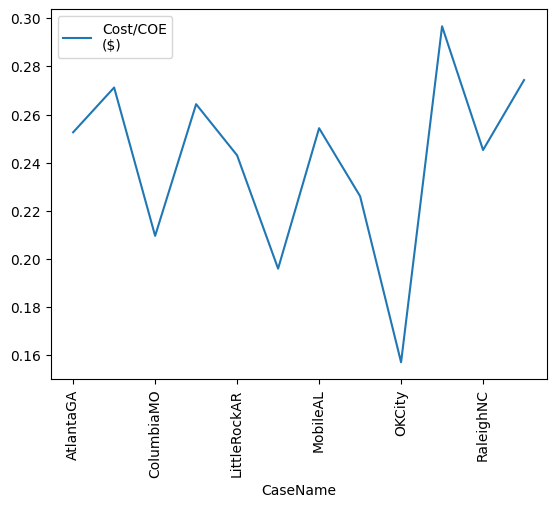

In [199]:
# DATA FOR LOC VAR
#for index = opt_out.ind 
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
CFA = opt_out.query("KCC=='cfa'")
#print(CFA.query("CaseNum=='Case1'"))
#CFA.plot(x='CaseName',y='Cost/COE\n($)')
Case1 = opt_out.loc[("Case1",slice(None))]
Case1CFA = Case1.query("KCC=='cfa'")
Case2 = opt_out.loc[("Case2",slice(None))]
Case2CFA = Case2.query("KCC=='cfa'")
Case25 = opt_out.loc[("Case25",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case3CFA = Case3.query("KCC=='cfa'")
Case35 = opt_out.loc[("Case35",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
Case4CFA = Case4.query("KCC=='cfa'")
display(Case4)
# Testing
Case5 = opt_out.loc[("Case5",slice(None))]
Case6 = opt_out.loc[("Case6",slice(None))]
Case7 = opt_out.loc[("Case7",slice(None))]
Case8 = opt_out.loc[("Case8",slice(None))]
Case10 = opt_out.loc[("Case10",slice(None))]
Case11 = opt_out.loc[("Case11",slice(None))]
Case12 = opt_out.loc[("Case12",slice(None))]
Case13 = opt_out.loc[("Case13",slice(None))]
Case14 = opt_out.loc[("Case14",slice(None))]
Case15 = opt_out.loc[("Case15",slice(None))]
Case16 = opt_out.loc[("Case16",slice(None))]
#display(Case16)
Case1CFA.plot(y='Cost/COE\n($)', use_index=True)

plt.xticks(rotation=90);


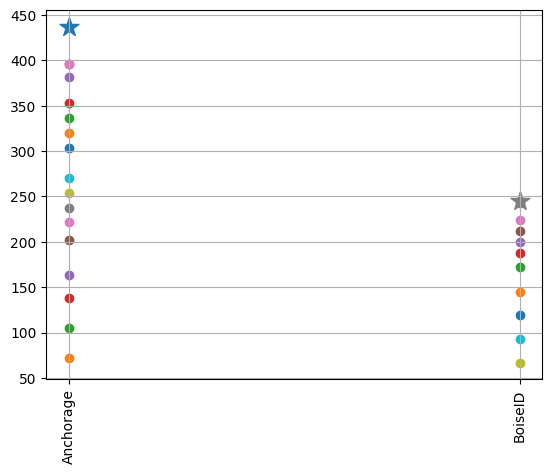

In [207]:
## STACKED BAR CHART TO DEMONSTRATE DATA BEFORE RAINBOW PLOT
fig, ax = plt.subplots()
bottom = np.zeros(3)
width = 0.5 

demo1 = 'Anchorage'

## make as a loop that doesn't break?
ax.scatter(demo1, Case1.loc[demo1]['Cost/COE\n($)']*1000,marker='*',s=200)
ax.scatter(demo1, Case2.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case25.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1, Case3.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case35.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1, Case4.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1, Case5.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1, Case6.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1, Case7.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1, Case8.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case10.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case11.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case12.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case13.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case14.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case15.loc[demo1]['Cost/COE\n($)']*1000)
ax.scatter(demo1,Case15.loc[demo1]['Cost/COE\n($)']*1000)
demo2 = 'BoiseID'
ax.scatter(demo2, Case1.loc[demo2]['Cost/COE\n($)']*1000,marker='*',s=200)
ax.scatter(demo2, Case2.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2,Case25.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2, Case3.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2,Case35.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2, Case4.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2, Case5.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2, Case6.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2, Case7.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2, Case8.loc[demo2]['Cost/COE\n($)']*1000)
ax.scatter(demo2,Case10.loc[demo2]['Cost/COE\n($)']*1000)


plt.xticks(rotation=90);
plt.grid(True)

<Figure size 640x480 with 0 Axes>

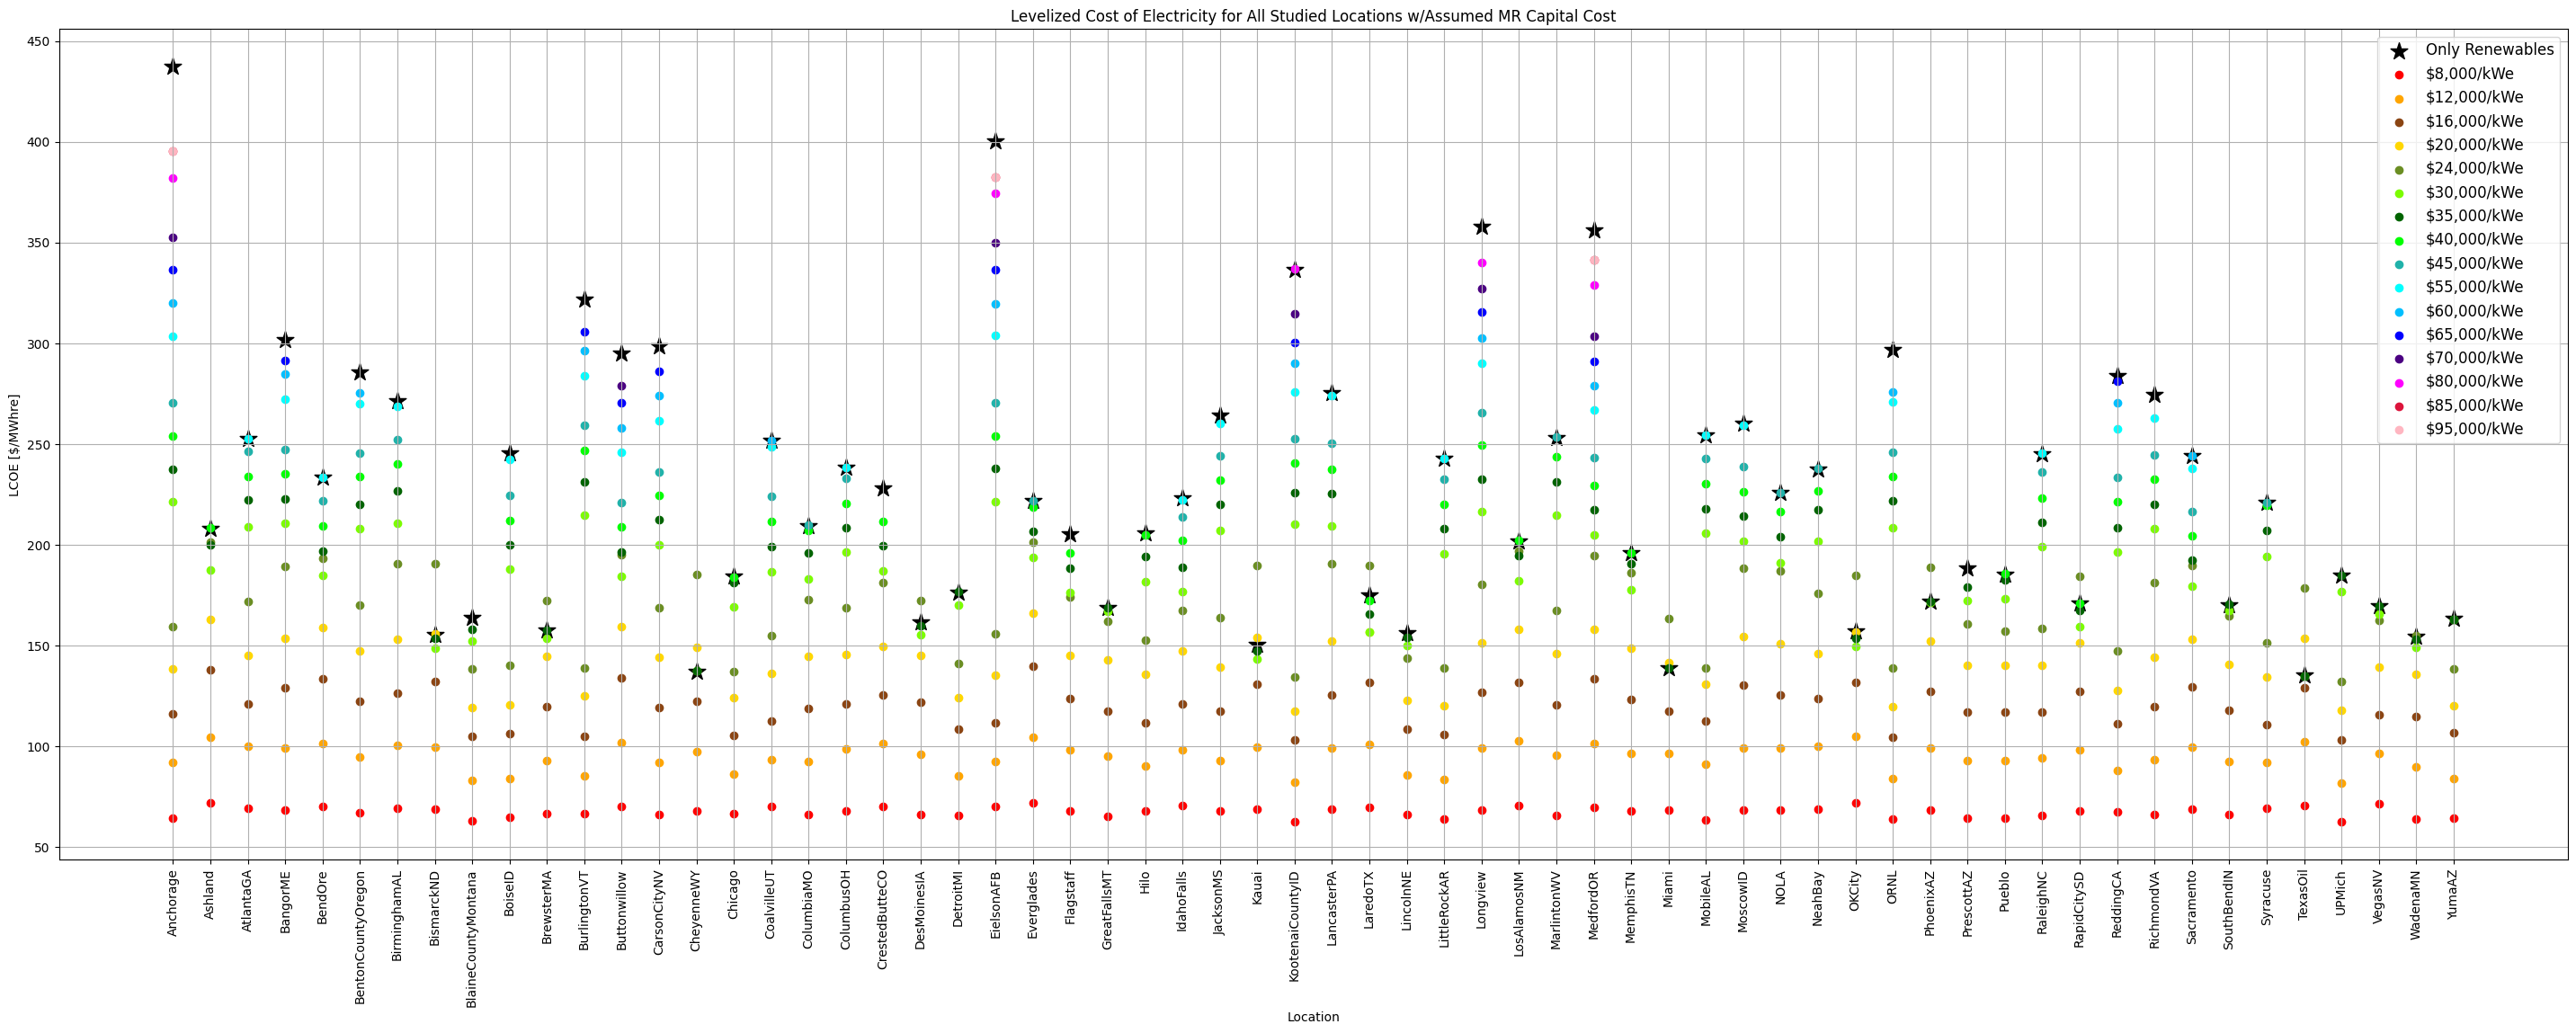

In [22]:
# KCC RAINBOW PLOT
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson', 'lightpink'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(36,12))
    ax.scatter( Case1.index.array, Case1['Cost/COE\n($)']*1000,marker='*',s=200)
    ax.scatter( Case1.index.array, Case2['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array,Case25['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array, Case3['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array,Case35['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array, Case4['Cost/COE\n($)']*1000)
    ax.scatter( Case5.index.array, Case5['Cost/COE\n($)']*1000)
    ax.scatter( Case6.index.array, Case6['Cost/COE\n($)']*1000)
    ax.scatter( Case7.index.array, Case7['Cost/COE\n($)']*1000)
    ax.scatter( Case8.index.array, Case8['Cost/COE\n($)']*1000)
    ax.scatter(Case10.index.array,Case10['Cost/COE\n($)']*1000)
    ax.scatter(Case11.index.array,Case11['Cost/COE\n($)']*1000)
    ax.scatter(Case12.index.array,Case12['Cost/COE\n($)']*1000)
    ax.scatter(Case13.index.array,Case13['Cost/COE\n($)']*1000)
    ax.scatter(Case14.index.array,Case14['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.legend(['Only Renewables', '$8,000/kWe','$12,000/kWe', 
               '$16,000/kWe', '$20,000/kWe','$24,000/kWe', '$30,000/kWe','$35,000/kWe','$40,000/kWe',
               '$45,000/kWe','$55,000/kWe','$60,000/kWe','$65,000/kWe','$70,000/kWe','$80,000/kWe',
               '$85,000/kWe','$95,000/kWe'], fontsize='large')
    plt.ylabel('LCOE [$/MWhre]')
    plt.xlabel('Location')
    plt.title('Levelized Cost of Electricity for All Studied Locations w/Assumed MR Capital Cost', fontsize='large')
    plt.xticks(rotation=90);
    ax.grid(True)


<Figure size 640x480 with 0 Axes>

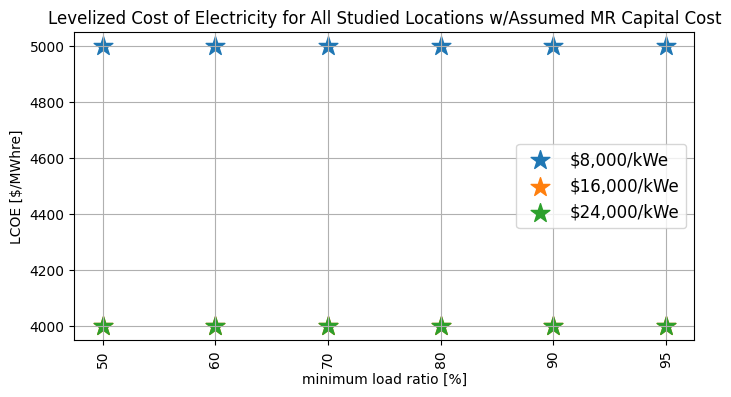

In [23]:
# DATA FOR MLR
#for index = opt_out.ind 
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
testcase = "Anchorage"
Case2= mlr_opt_out.loc[("Case2",slice(None))]
Case3= mlr_opt_out.loc[("Case3",slice(None))]
Case4= mlr_opt_out.loc[("Case4",slice(None))]
Case2test = Case2.loc[(testcase,slice(None))]
Case3test = Case3.loc[(testcase,slice(None))]
Case4test = Case4.loc[(testcase,slice(None))]
fig = plt.figure()
fig, ax=plt.subplots(figsize=(8,4))
# 'Architecture/GenLarge\n(kW)'
ax.scatter( Case2test.index.array, Case2test['Architecture/GenLarge\n(kW)'],marker='*',s=200)
ax.scatter( Case3test.index.array, Case3test['Architecture/GenLarge\n(kW)'],marker='*',s=200)
ax.scatter( Case4test.index.array, Case4test['Architecture/GenLarge\n(kW)'],marker='*',s=200)
ax.legend(['$8,000/kWe','$16,000/kWe','$24,000/kWe'], fontsize='large')
plt.ylabel('LCOE [$/MWhre]')
plt.xlabel('minimum load ratio [%]')
plt.title('Levelized Cost of Electricity for All Studied Locations w/Assumed MR Capital Cost', fontsize='large')
plt.xticks(rotation=90);
ax.grid(True)

plt.savefig("mlr_testing")

In [74]:
# DATA FOR util
low = util_opt_out.loc[("1.3MWe",slice(None))]
high = util_opt_out.loc[("2.6MWe",slice(None))]
display(low)
display(high)

Architecture/PV\n(kW)  Grid/Energy Purchased\n(kWh)  \
Price CaseName  KCC                                                        
12    Anchorage dfc           76800.800000                    5108567.00   
      Ashland   dfb           37469.778374                    3765344.50   
      AtlantaGA cfa           86083.370265                    6029559.50   
      BangorME  dfb           61569.338073                    5329595.50   
      BendOre   bsk           33742.500745                    4773864.50   
...                                    ...                           ...   
6     TexasOil  bsh           14611.443635                    4104589.75   
      UPMich    dfb           43145.927351                    3476247.00   
      VegasNV   bwh           28984.103688                    5524351.50   
      WadenaMN  dfa           17883.455890                    3594086.50   
      YumaAZ    bwh           37010.294715                    5900801.50   

                    Architecture/G1500 Architecture/1kWh LI  Cost/COE\n($)  
Price CaseName  KCC                                                         
12    Anchorage dfc                 19               133933       0.323477  
      Ashland   dfb                 14                59708       0.174181  
      AtlantaGA cfa                  2                70298       0.207359  
      BangorME  dfb                  8                98826       0.227301  
      BendOre   bsk                 12                74259       0.180699  
...                                ...                  ...            ...  
6     TexasOil  bsh                  7                49555       0.103177  
      UPMich    dfb                 11                49106       0.151799  
      VegasNV   bwh                  5                61121       0.127779  
      WadenaMN  dfa                  9                51198       0.115601  
      YumaAZ    bwh                  3                60090       0.129655  

[310 rows x 5 columns]

Architecture/PV\n(kW)  Grid/Energy Purchased\n(kWh)  \
Price CaseName  KCC                                                        
12    Anchorage dfc           51260.488144                    12587906.0   
      Ashland   dfb           31857.000867                     7956376.0   
      AtlantaGA cfa           53323.749534                    12503425.0   
      BangorME  dfb           51088.173894                    11771956.0   
      BendOre   bsk           26260.764409                    11341762.0   
...                                    ...                           ...   
6     TexasOil  bsh            9868.654810                     7956019.5   
      UPMich    dfb           20787.229111                     6746716.5   
      VegasNV   bwh           20565.506421                    12421933.0   
      WadenaMN  dfa           13802.910637                     7630152.5   
      YumaAZ    bwh           23972.819896                    12382070.0   

                    Architecture/G1500 Architecture/1kWh LI  Cost/COE\n($)  
Price CaseName  KCC                                                         
12    Anchorage dfc                  5                66206       0.194136  
      Ashland   dfb                  9                33291       0.135178  
      AtlantaGA cfa                NaN                47365       0.157814  
      BangorME  dfb                  3                48532       0.165122  
      BendOre   bsk                  4                38063       0.126003  
...                                ...                  ...            ...  
6     TexasOil  bsh                  6                24838       0.074369  
      UPMich    dfb                 10                36086       0.112565  
      VegasNV   bwh                  1                36208       0.088137  
      WadenaMN  dfa                  6                25410       0.079242  
      YumaAZ    bwh                1.0                37466       0.093565  

[310 rows x 5 columns]

<Figure size 640x480 with 0 Axes>

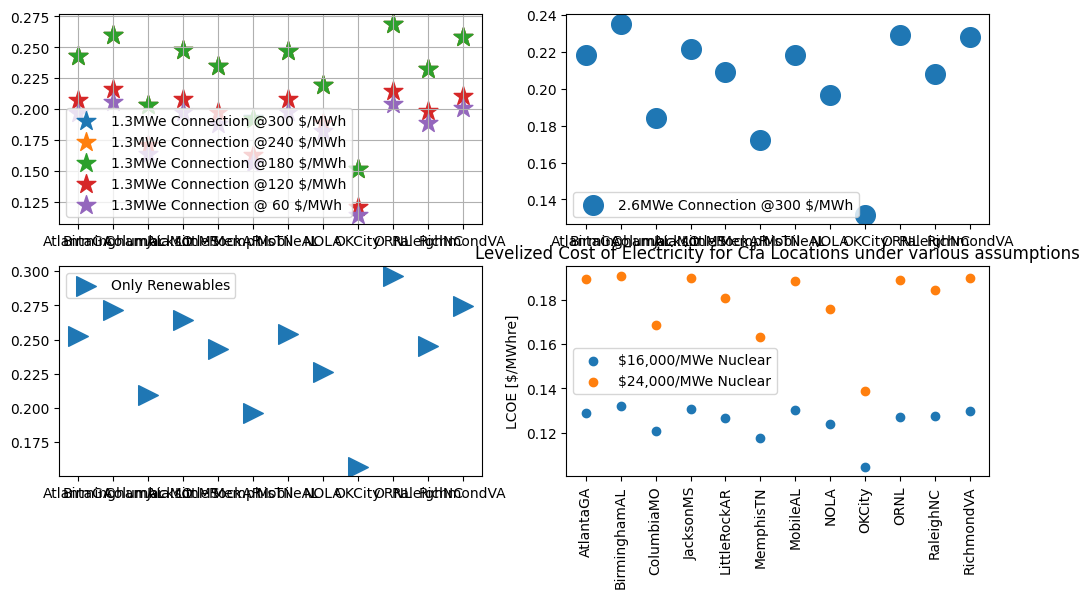

In [195]:
## Comparing high utility throughput to low utility throughput 
low_30 = low.query("Price=='30' & KCC=='cfa'")
low_24 = low.query("Price=='24' & KCC=='cfa'")
low_18 = low.query("Price=='18' & KCC=='cfa'")
low_12 = low.query("Price=='12' & KCC=='cfa'")
low_06 = low.query("Price=='6' & KCC=='cfa'")

high_30 = high.query("Price=='30' & KCC=='cfa'")

# fig = plt.figure()
# fig, ax=plt.subplots(figsize=(12,6))
# ax.scatter( low_30.droplevel(['Price','KCC']).index.array, low_30['Grid/Energy Purchased\n(kWh)'].array,marker='*',s=200)
# ax.scatter( high_30.droplevel(['Price','KCC']).index.array, high_30['Grid/Energy Purchased\n(kWh)'].array,marker='*',s=200)
# ax.legend(['1.3MWe Connection', '2.6MWe Connection'], fontsize='large')
# plt.ylabel('Grid Energy Purchased (kWh)')
# plt.xlabel('Location (KCC = Cfa)')
# plt.title('Levelized Cost of Electricity for All Studied Locations w/Assumed MR Capital Cost', fontsize='large')
# plt.xticks(rotation=90);
# ax.grid(True);
axes = [ax1, ax2, ax3, ax4]
fig = plt.figure()
fig, ((ax1, ax2),(ax3, ax4)) =plt.subplots(2,2,figsize=(12,6))
ax2.scatter(high_30.droplevel(['Price','KCC']).index.array,  high_30['Cost/COE\n($)'].array,marker='o',s=200)
plt.xticks(rotation=90);

ax1.scatter( low_30.droplevel(['Price','KCC']).index.array,   low_30['Cost/COE\n($)'].array,marker='*',s=200)
ax1.scatter( low_24.droplevel(['Price','KCC']).index.array,   low_24['Cost/COE\n($)'].array,marker='*',s=200)
ax1.scatter( low_18.droplevel(['Price','KCC']).index.array,   low_18['Cost/COE\n($)'].array,marker='*',s=200)
ax1.scatter( low_12.droplevel(['Price','KCC']).index.array,   low_12['Cost/COE\n($)'].array,marker='*',s=200)
ax1.scatter( low_06.droplevel(['Price','KCC']).index.array,   low_06['Cost/COE\n($)'].array,marker='*',s=200)
plt.ylabel('LCOE for 1.3MWe utility connection')
plt.xticks(rotation=90);

ax3.scatter( Case1CFA.index.array, Case1CFA['Cost/COE\n($)'],marker='>',s=200)
ax4.scatter( Case1CFA.index.array, Case3CFA['Cost/COE\n($)'])
ax4.scatter( Case1CFA.index.array, Case4CFA['Cost/COE\n($)'])
plt.xticks(rotation=90);

ax2.legend(['2.6MWe Connection @300 $/MWh'])
ax1.legend(['1.3MWe Connection @300 $/MWh',
            '1.3MWe Connection @240 $/MWh',
            '1.3MWe Connection @180 $/MWh',
            '1.3MWe Connection @120 $/MWh',
            '1.3MWe Connection @ 60 $/MWh'])
ax3.legend(['Only Renewables'])
ax4.legend(['$16,000/MWe Nuclear', '$24,000/MWe Nuclear'])

plt.ylabel('LCOE [$/MWhre]')
plt.title('Levelized Cost of Electricity for Cfa Locations under various assumptions', fontsize='large')
plt.xticks(rotation=90);
ax1.grid(True);

# high_30.plot(y='Cost/COE\n($)', use_index=True)
# plt.xticks(rotation=90);
# plt.ylim([0.10  ,0.3])

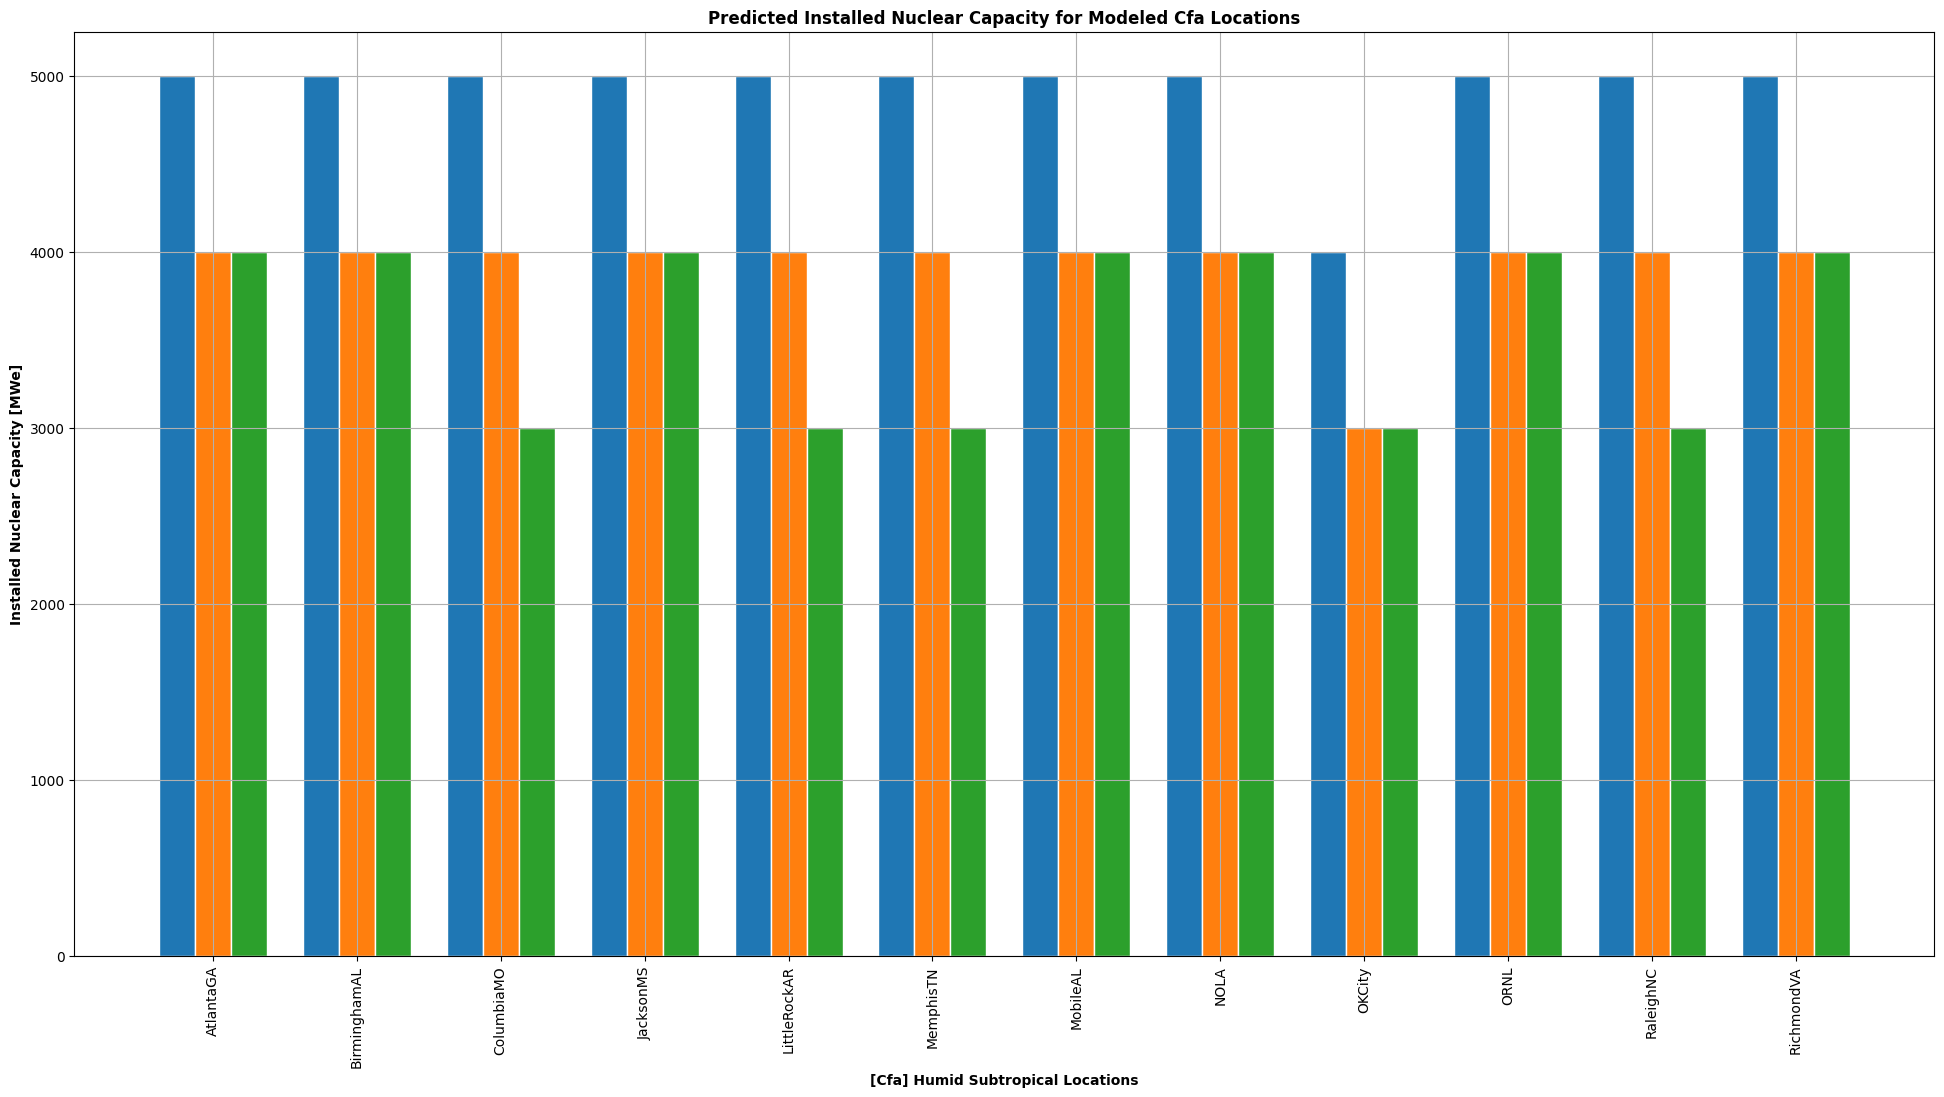

In [72]:
m = len(Case2CFA)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2CFA["Architecture/GenLarge\n(kW)"]
#bars15 = Case25CFA["Architecture/GenLarge\n(kW)"]
bars2 = Case3CFA["Architecture/GenLarge\n(kW)"]
#bars25 = Case35CFA["Architecture/GenLarge\n(kW)"]
bars3 = Case4CFA["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
#r15 = [x+barWidth for x in r1]
r2 = [x+barWidth for x in r1]
#r25 = [x+barWidth for x in r2]
r3 = [x+barWidth for x in r2]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
#plt.bar(r15, bars15, width=barWidth, edgecolor='white', label='LoMidCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
#plt.bar(r25, bars25, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.ylabel('Installed Nuclear Capacity [MWe]',fontweight='bold')
plt.xlabel('[Cfa] Humid Subtropical Locations',fontweight='bold')
plt.title('Predicted Installed Nuclear Capacity for Modeled Cfa Locations',fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2CFA.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 


In [ ]:
# Initial KCC Plots
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(12,6))
    #ax.scatter( Case1CFA.index.array, Case1CFA['Architecture/GenLarge\n(kW)']*1000,marker='*',s=200)
    ax.bar( Case2CFA.index.array, Case2CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case3CFA.index.array, Case3CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case4CFA.index.array, Case4CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.legend([ 'LowCostNuclear', 'MidCostNuclear', 'HighCostNuclear'], fontsize='large')
    plt.ylabel('Installed Nuclear Capacity [MWe]')
    plt.xlabel('[Cfa] Humid Subtropical Locations')
    plt.xticks(rotation=90);
    #plt.yticks([3,4,5])
    ax.grid(True)